# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning
Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Dataset ipotesi: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

Questo dataset non va bene perchè ha fatto data aug sul validation dataset, fallback al plant village originale: https://www.tensorflow.org/datasets/catalog/plant_village

In [1]:
# Initial imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import tensorflow as tf
import tensorflow_datasets as tfds

import os
import sys
sys.path.append('./src')
import pickle

# from tqdm.notebook import tqdm


In [2]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Seed setting for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)


## Load the PlantVillage dataset from TFDS

In [4]:
(ds_train, ds_val), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:95%]'],
    shuffle_files=[True, False],
    as_supervised=True,  # returns (image, label) pairs
    with_info=True
)

# print the number of elements in each dataset
print(f"Number of training images: {ds_info.splits['train[:80%]'].num_examples}")
print(f"Number of validation images: {ds_info.splits['train[80%:95%]'].num_examples}")


Number of training images: 43442
Number of validation images: 8146


2025-07-24 09:58:29.521516: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-07-24 09:58:29.521542: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-07-24 09:58:29.521545: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2025-07-24 09:58:29.521571: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-24 09:58:29.521590: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


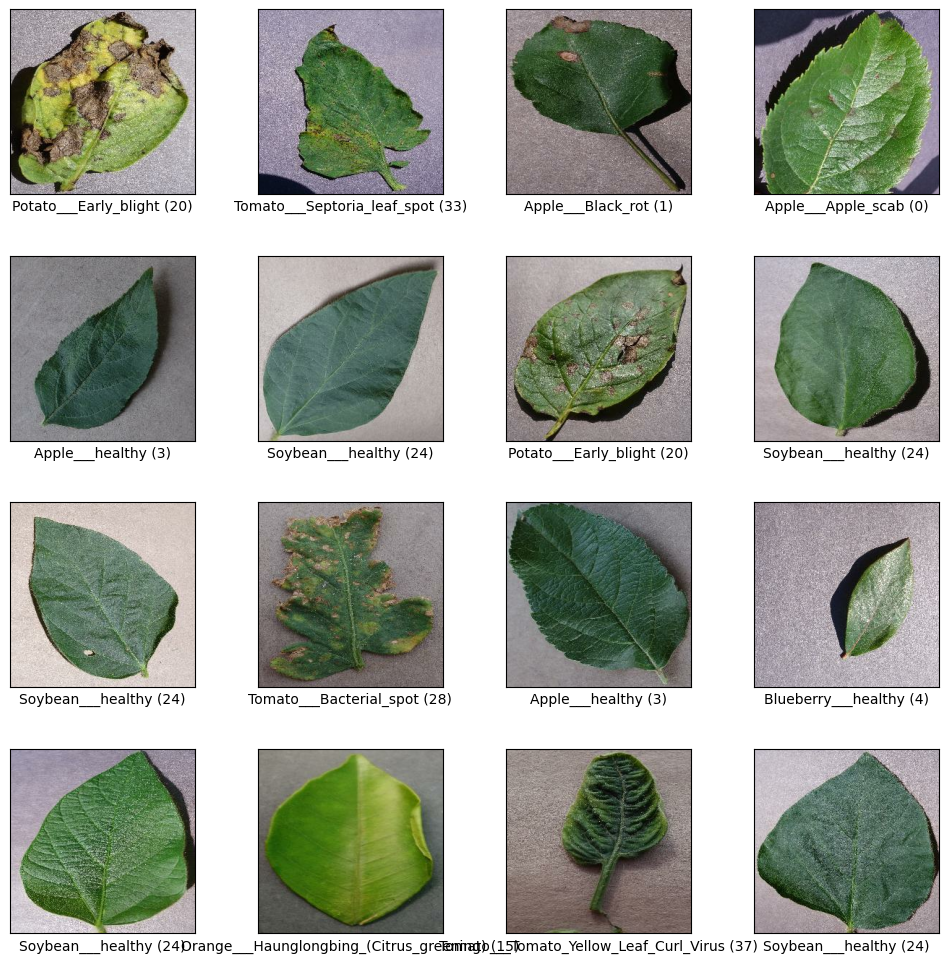

In [5]:
# Show example from the dataset
SAVE_EXAMPLES = False  # Set to True to save the example images
fig = tfds.show_examples(ds_train, ds_info, rows=4, cols=4,)
if SAVE_EXAMPLES:
    fig.savefig('example_images.png')


In [6]:
# Extract only labels (not images) for counting
labels_list = []
for _, label in ds_train:
    labels_list.append(label.numpy())

# Convert to pandas Series for fast operations
labels_series = pd.Series(labels_list)

number_of_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {number_of_classes}")
class_names = ds_info.features['label'].names

# Count using pandas (fast) but memory-efficient
class_counts = labels_series.value_counts().sort_index()

# Print the counts with class names
print("Number of images per class:")
for idx, count in class_counts.items():
    print(f"{class_names[idx]}: {count} images")


Number of classes: 38
Number of images per class:
Apple___Apple_scab: 501 images
Apple___Black_rot: 467 images
Apple___Cedar_apple_rust: 221 images
Apple___healthy: 1306 images
Blueberry___healthy: 1210 images
Cherry___healthy: 659 images
Cherry___Powdery_mildew: 851 images
Corn___Cercospora_leaf_spot Gray_leaf_spot: 405 images
Corn___Common_rust: 953 images
Corn___healthy: 939 images
Corn___Northern_Leaf_Blight: 788 images
Grape___Black_rot: 956 images
Grape___Esca_(Black_Measles): 1111 images
Grape___healthy: 349 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 881 images
Orange___Haunglongbing_(Citrus_greening): 4399 images
Peach___Bacterial_spot: 1838 images
Peach___healthy: 292 images
Pepper,_bell___Bacterial_spot: 800 images
Pepper,_bell___healthy: 1173 images
Potato___Early_blight: 792 images
Potato___healthy: 122 images
Potato___Late_blight: 801 images
Raspberry___healthy: 302 images
Soybean___healthy: 4043 images
Squash___Powdery_mildew: 1466 images
Strawberry___healthy: 353

### Visualize the class distribution in the training dataset

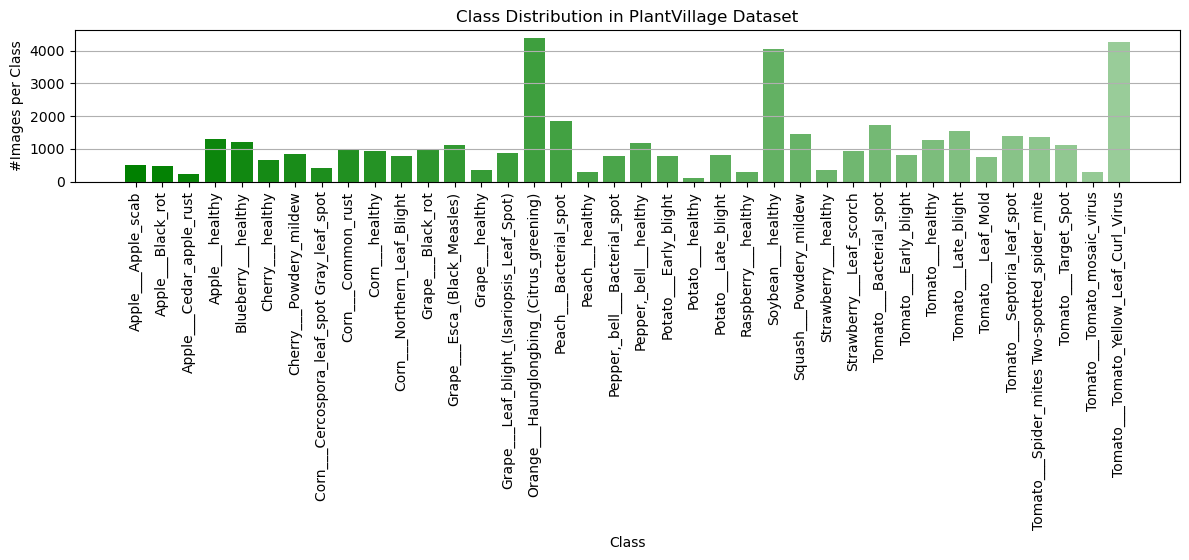

In [8]:
NORMALIZE = False  # Set to True to normalize the counts

plt.figure(figsize=(12, 6))
alphas = np.linspace(1, 0.4, ds_info.features['label'].num_classes)
for (name, count, alpha) in zip(class_names, class_counts, alphas):
    plt.bar(name, count / (np.sum(class_counts) if NORMALIZE else 1), color='green', alpha=alpha)
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.grid(axis='y')
if NORMALIZE:
    plt.ylabel('Normalized #Images per Class')
    plt.title('Normalized Class Distribution in PlantVillage Dataset')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add this line to leave space for the title
    plt.savefig('norm_class_distr.png')
else:
    plt.ylabel('#Images per Class')
    plt.title('Class Distribution in PlantVillage Dataset')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add this line to leave space for the title
    plt.savefig('class_distr.png')
plt.show()


In [9]:
# setup constants
NUM_CLASSES         = ds_info.features['label'].num_classes

ARCH_CHOICE         = 0 # 0: simple_cnn_v0, 1: simple_cnn_v1, 2: simple_cnn_v2, 3: simple_cnn_v3

WEIGHTS_DIR = './weights'
HISTORY_DIR = './train-hist'
os.makedirs(WEIGHTS_DIR, exist_ok=True)
os.makedirs(HISTORY_DIR, exist_ok=True)
CHECKPOINT_FILE = f'{WEIGHTS_DIR}/best_model_v{ARCH_CHOICE}.h5'
HISTORY_FILE = f'{HISTORY_DIR}/history_v{ARCH_CHOICE}'

IMG_SIZE            = (128, 128) # Image size for resizing in preprocessing
IMG_CHANNELS        = 3          # Number of channels in the images (RGB)
BATCH_SIZE          = 64         # Batch size for training
N_EPOCHS            = 50         # Number of epochs for training
STARTING_LR         = 0.0002     # Starting learning rate for the optimizer
EARLY_STOP_PATIENCE = 4          # Patience for early stopping
REDUCE_LR_PATIENCE  = 3          # Patience for reducing learning rate



## Preprocess and batch the datasets

In [10]:
from preprocessing import preprocess

train_ds = ds_train.map(lambda image, label: preprocess(image, label, ds_info, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = ds_val.map  (lambda image, label: preprocess(image, label, ds_info, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


## Build the architectures

In [11]:
from keras.models import Sequential, Model
from keras.layers import Input, Activation, BatchNormalization, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, ReLU, Rescaling, Add 
from keras.optimizers.legacy import Adam, SGD
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.applications import ResNet50, InceptionV3, VGG16, MobileNetV2, EfficientNetB0


In [12]:
def simple_cnn_v0(input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS),
                   num_classes=NUM_CLASSES,
                   drop_rate=0.4,
                #    l2_reg=0.005,
                   ):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Dropout(drop_rate),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [13]:
def simple_cnn_v1(input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS),
                  num_classes=NUM_CLASSES,
                  drop_rate=0.4,
                  #l2_reg=0.005,
                   ):
    model = Sequential([
        Conv2D(16, (3, 3), padding='same', input_shape=input_shape),
        Activation('relu'),
        Dropout(drop_rate),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        Conv2D(64, (3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [14]:
def simple_cnn_v2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS),
                  num_classes=NUM_CLASSES,
                  drop_rate=0.4,
                  l2_reg=0.005,
                  ):
    model = Sequential([
        Conv2D(16, (3, 3), padding='same', kernel_regularizer=l2(l2_reg), input_shape=input_shape),
        Activation('relu'),
        Dropout(drop_rate),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(l2_reg)),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_reg)),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        Flatten(),
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))
    ])
    return model


In [15]:
def simple_cnn_v3(input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS),
                  num_classes=NUM_CLASSES,
                  drop_rate=0.4,
                  #l2_reg=0.005,
                   ):
    model = Sequential([
        Conv2D(16, (3, 3), padding='same', input_shape=input_shape),
        Activation('relu'),
        Dropout(drop_rate),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        Conv2D(64, (3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        Conv2D(128, (3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(drop_rate),

        GlobalAveragePooling2D(),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [16]:
models_list = [simple_cnn_v0,
               simple_cnn_v1,
               simple_cnn_v2,
               simple_cnn_v3,
               ]
if ARCH_CHOICE not in range(0, len(models_list) + 1):
    raise ValueError("Invalid architecture choice")
else:
    model = models_list[ARCH_CHOICE]()

model.build(input_shape=(None, IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS))  # Build the model with dynamic batch size
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0

In [17]:
optimizer = Adam(learning_rate=0.0002)
model.compile(
    optimizer=optimizer,
    # loss=CategoricalCrossentropy(label_smoothing=0.1),
    loss=CategoricalCrossentropy(),
    # loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics=['accuracy']
)


### Calculate class weights for weighted training

In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get all labels from the training set
labels = []
for _, label in ds_train:
    labels.append(label.numpy())
labels = np.array(labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict


{0: 2.2818573379556675,
 1: 2.4479882790487997,
 2: 5.172898309121219,
 3: 0.8753526235189812,
 4: 0.9448020878642889,
 5: 1.734765593802412,
 6: 1.343373121405158,
 7: 2.8227420402859,
 8: 1.1995913182747004,
 9: 1.2174765988453562,
 10: 1.4507747795885653,
 11: 1.1958269103721648,
 12: 1.0289923729215027,
 13: 3.275674860503695,
 14: 1.2976282932074796,
 15: 0.25987963771670597,
 16: 0.6219861405417788,
 17: 3.915104542177361,
 18: 1.429013157894737,
 19: 0.9746040292547224,
 20: 1.4434476342371079,
 21: 9.370578084555651,
 22: 1.4272291214928707,
 23: 3.7854653189264553,
 24: 0.2827629300805811,
 25: 0.7798161843900338,
 26: 3.238556731772775,
 27: 1.2385812852825455,
 28: 0.6600522669259754,
 29: 1.4166177525598382,
 30: 0.9065904253099044,
 31: 0.7447625578604492,
 32: 1.5081933064852104,
 33: 0.8113630420977924,
 34: 0.8405959752321981,
 35: 1.0170912155834426,
 36: 3.7729720340455097,
 37: 0.268864187750656}

## Train the selected architecture
Or just visualize the training history of an already-trained model

In [19]:
# Dummy class to mimic Keras History for plotting
class DummyHistory:
    def __init__(self, history_dict):
        self.history = history_dict


In [20]:
TRAIN = False  # Change to False to only visualize an already trained model's history

if TRAIN:
    # Train the model
    print(f"Training the model v{ARCH_CHOICE}...")
    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=N_EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_accuracy',
                    #   min_delta=0.005,
                      patience=EARLY_STOP_PATIENCE,
                      restore_best_weights=True,
                      verbose=1),
        ModelCheckpoint(CHECKPOINT_FILE,
                        # min_delta=0.005,
                        monitor='val_accuracy',
                        save_best_only=True,
                        verbose=1),
        ReduceLROnPlateau(monitor='val_accuracy',
                        #   min_delta=0.005,
                          factor=0.2,
                          patience=REDUCE_LR_PATIENCE,
                          verbose=1)
    ],
    class_weight=class_weights_dict,
    )
    # Save history after training
    with open(HISTORY_FILE+'.pkl', 'wb') as f:
        pickle.dump(history.history, f)
else:
    # Load history if not training
    with open(HISTORY_FILE+'.pkl', 'rb') as f:
        loaded_history = pickle.load(f)
        history = DummyHistory(loaded_history)


### Visualize the model training history

Plotting model history for architecture v0...


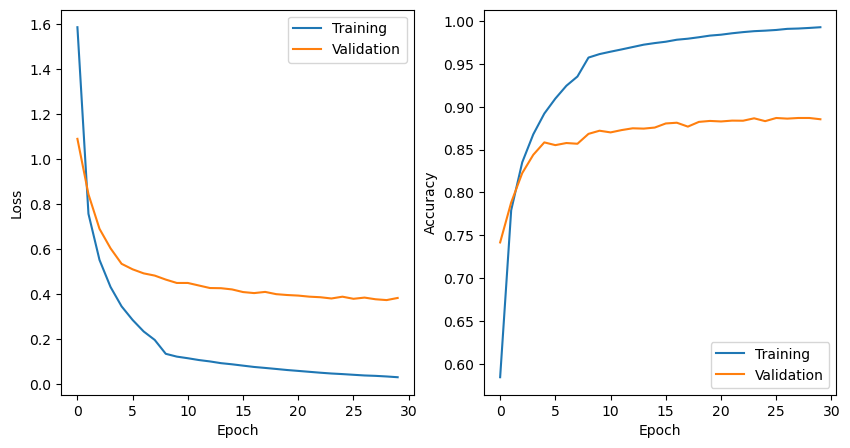

In [22]:
from plotting import plot_model_history

print(f"Plotting model history for architecture v{ARCH_CHOICE}...")
plot_model_history(history)
plt.savefig(HISTORY_FILE+'.png', dpi=400, bbox_inches='tight')
